<a href="https://colab.research.google.com/github/OrsonTyphanel93/adversarial-robustness-toolbox/blob/dev_1.14.0/The_END_Last_update_ART_dynamic_backdoor_attacks_trigger_stacking_(_Audio).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook shows how to use ART to create a dynamic backdoor trigger stacking , regardless of the position of the audio trigger.

In [ ]:
#!pip install numpy==1.23.5
!pip install numpy==1.25.2

In [ ]:
'''
install library which is not already installed
'''
!pip3 install adversarial-robustness-toolbox matplotlib ipywidgets
!pip install tensorflow==2.9
!pip3 install laplace-torch
!pip3 install --upgrade cryptography
!pip3 install nemo_toolkit['all']

In [ ]:
from IPython.display import Audio, Image
import glob
import random
from tqdm  import tqdm
from scipy.io import wavfile
import numpy as np
import librosa

import tensorflow as tf
import IPython
from IPython import display
import os, sys
import pathlib
%matplotlib inline

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art import config
from art.estimators.classification import TensorFlowV2Classifier

# Set the seed value for experiment reproducibility.
seed = 72
tf.random.set_seed(seed)
np.random.seed(seed)

# TIMIT dataset

In [ ]:
%%capture
!pip install datasets==1.18.3

In [ ]:
from datasets import load_dataset
from tqdm.notebook import tqdm
import os; import psutil; import timeit

#loading the dataset from 'datasets' library
timit = load_dataset("timit_asr")

Downloading:   0%|          | 0.00/2.40k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset timit_asr downloaded and prepared to /root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/b11b576ddcccbcefa7c9f0c4e6c2a43756f3033adffe0fb686aa61043d0450ad. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from IPython import display
import tensorflow as tf
import librosa
import numpy as np
import os

# Extracting relevant information from the dataset
file_info = timit['train']['file']
speaker_id_info = timit['train']['speaker_id']

# Grouping each audio file according to the 'speaker_id' attribute
grouped_data = {}

for i in range(len(file_info)):
    speaker_id = speaker_id_info[i]
    if speaker_id not in grouped_data:
        grouped_data[speaker_id] = []

    file_data = {
        'file': file_info[i],
        'speaker_id': speaker_id_info[i],
    }

    grouped_data[speaker_id].append(file_data)

# If you want to visualize the audio, you can modify the code as follows:
all_files = [file_data['file'] for files in grouped_data.values() for file_data in files]

# Shuffle the files
filenames = tf.random.shuffle(all_files).numpy()
example_files = filenames[:2000]

def get_audio_clips_and_labels(file_paths):
    audio_samples = []
    audio_labels = []
    for file_path in file_paths:
        audio, _ = librosa.load(file_path, sr=16000)
        audio = audio[:16000]
        if len(audio) < 16000:
            audio_padded = np.zeros(16000)
            audio_padded[:len(audio)] = audio
            audio = audio_padded
        label = tf.strings.split(
                        input=file_path,
                        sep=os.path.sep)[-2]

        audio_samples.append(audio)
        audio_labels.append(label.numpy().decode("utf-8") )
    return np.stack(audio_samples), np.stack(audio_labels)


x_audio, y_audio = get_audio_clips_and_labels(example_files)

# Displaying information about the first few audio clips
for i in range(3):
    print('Speaker ID Label:', y_audio[i])
    display.display(display.Audio(x_audio[i], rate=16000))


Speaker ID Label: MKLS1


Speaker ID Label: FCMG0


Speaker ID Label: MDTB0


In [ ]:
# Create an array of speaker IDs
speaker_ids = np.array(list(set(y_audio)))
commands = np.array(list(set(y_audio)))

In [ ]:
print('speaker_ids',speaker_ids)

In [ ]:
# Displaying information about the first few audio clips
for i in range(9):
    print('Speaker ID Label:', y_audio[i])
    display.display(display.Audio(x_audio[i], rate=16000))

Speaker ID Label: MKLS1


Speaker ID Label: FCMG0


Speaker ID Label: MDTB0


Speaker ID Label: MDHS0


Speaker ID Label: MRLJ1


Speaker ID Label: MKLS0


Speaker ID Label: MSAS0


Speaker ID Label: MCDR0


Speaker ID Label: MJLG1



#Free Spoken Digit Dataset (FSDD)

We will use  the speech Free Spoken Digit ([A. A. Ramadan , all ](https://ieeexplore.ieee.org/abstract/document/10206077)). This dataset contains audio clips of several commands, e.g., '0', '4', '9'.[link](https://github.com/Jakobovski/free-spoken-digit-dataset/)


In [ ]:
import os
import tarfile
import requests

# Define the URL of the dataset and the local directory where you want to store it
dataset_url = "https://github.com/Jakobovski/free-spoken-digit-dataset/archive/v1.0.9.tar.gz"
download_dir = "spoken_digits"

# Create the directory if it doesn't exist
os.makedirs(download_dir, exist_ok=True)

# Download the dataset file
response = requests.get(dataset_url)

if response.status_code == 200:
    # Save the dataset to a local file
    with open(os.path.join(download_dir, "dataset.tar.gz"), "wb") as file:
        file.write(response.content)

    # Extract the dataset
    with tarfile.open(os.path.join(download_dir, "dataset.tar.gz"), "r:gz") as tar:
        tar.extractall(download_dir)

    # Rename the extracted directory to a more descriptive name
    extracted_dir = os.path.join(download_dir, "free-spoken-digit-dataset-1.0.9")
    os.rename(extracted_dir, os.path.join(download_dir, "dataset"))

    # Organize the audio files by their labels
    dataset_dir = os.path.join(download_dir, "dataset")
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(".wav"):
                label = file.split("_")[0]  # Extract the label from the file name
                label_dir = os.path.join(download_dir, label)
                os.makedirs(label_dir, exist_ok=True)
                os.rename(os.path.join(root, file), os.path.join(label_dir, file))

    print("Dataset downloaded and organized by labels.")
else:
    print("Failed to download the dataset.")

Dataset downloaded and organized by labels.


The dataset's audio clips are stored in eight folders corresponding to each spoken_digits: '0', '1', '2', '3', '4', '5', '6', '7', '8','9'

In [ ]:
commands = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8','9'])

In [ ]:
import os
import shutil

# Define the paths to the directory and file you want to delete
dataset_dir = "spoken_digits/dataset"
tar_file = "spoken_digits/dataset.tar.gz"

# Check if the directory and file exist before attempting to delete
if os.path.exists(dataset_dir):
    shutil.rmtree(dataset_dir)  # Delete the directory and its contents
    print(f"Deleted directory: {dataset_dir}")

if os.path.exists(tar_file):
    os.remove(tar_file)  # Delete the file
    print(f"Deleted file: {tar_file}")

Deleted directory: spoken_digits/dataset
Deleted file: spoken_digits/dataset.tar.gz


In [ ]:
data_dir = '/content/spoken_digits'
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames).numpy()
example_files = filenames[:2000]



Now, let's define a function that preprocesses the dataset's raw WAV audio files into audio tensors. Audio clips are sampled at 16kHz, and are less than or equal to 1 second. If an audio clip is smaller than 1 second, then we zero pad the data.


In [ ]:
def get_audio_clips_and_labels(file_paths):
    audio_samples = []
    audio_labels = []
    for file_path in file_paths:
        audio, _ = librosa.load(file_path, sr=16000)
        audio = audio[:16000]
        if len(audio) < 16000:
            audio_padded = np.zeros(16000)
            audio_padded[:len(audio)] = audio
            audio = audio_padded
        label = tf.strings.split(
                        input=file_path,
                        sep=os.path.sep)[-2]

        audio_samples.append(audio)
        audio_labels.append(label.numpy().decode("utf-8") )
    return np.stack(audio_samples), np.stack(audio_labels)

In [ ]:
x_audio, y_audio = get_audio_clips_and_labels(example_files)
for i in range(3):
    print('Label:', y_audio[i])
    display.display(display.Audio(x_audio[i], rate=16000))

Label: 7


Label: 4


Label: 8


#Creating clean-label backdoor attacks



In [ ]:

import numpy as np
import librosa
import logging

logging.basicConfig(level=logging.INFO)  # Set the desired logging level


class CacheTrigger:
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        trigger: np.ndarray,
        random: bool = False,
        shift: int = 0,
        imperceptibility: float = 0.1,
    ):
        """
        Initialize a CacheTrigger instance.
        :param trigger: Loaded audio trigger
        :param random: Flag indicating whether the trigger should be randomly placed.
        :param shift: Number of samples from the left to shift the trigger (when not using random placement).
        :param imperceptibility: Scaling factor for mixing the trigger.
        """
        if not isinstance(trigger, np.ndarray):
            raise TypeError("Trigger must be a NumPy array.")
        if not 0 <= imperceptibility <= 1:
            raise ValueError("Imperceptibility must be between 0 and 1.")

        self.trigger = trigger
        self.scaled_trigger = self.trigger * imperceptibility
        self.random = random
        self.shift = shift
        self.imperceptibility = imperceptibility

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Insert a backdoored trigger into audio.
        :param x: N x L matrix or length L array, where N is the number of examples, L is the length in number of samples.
                  x is in the range [-1, 1].
        :return: Backdoored audio.
        """
        if len(x.shape) == 2:
            return np.array([self.insert(single_audio) for single_audio in x])

        if len(x.shape) != 1:
            raise ValueError(f"Invalid array shape: {x.shape}")

        original_dtype = x.dtype
        audio = np.copy(x)
        length = audio.shape[0]
        bd_length = self.trigger.shape[0]

        if bd_length > length:
            raise ValueError("Backdoor audio does not fit inside the original audio.")

        if self.random:
            shift = np.random.randint(length - bd_length)
        else:
            shift = self.shift

        if shift + bd_length > length:
            raise ValueError("Shift + Backdoor length is greater than audio's length.")

        audio[shift: shift + bd_length] += self.scaled_trigger[:bd_length]
        audio = np.clip(audio, -1.0, 1.0)
        return audio.astype(original_dtype)


class CacheAudioTrigger(CacheTrigger):
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        backdoor_path: str = "/content/triggers_clapping.wav",
        duration: float = None,
        imperceptibility: float = 0.1,
        scale: float = 0.1,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheAudioTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param backdoor_path: The path to the audio to insert as a trigger.
        :param duration: Duration of the trigger in seconds. Default `None` if the full trigger is to be used.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        try:
            trigger, bd_sampling_rate = librosa.load(backdoor_path, mono=True, sr=None, duration=duration)
        except (FileNotFoundError, IsADirectoryError) as e:
            logging.error(f"Error loading backdoor audio: {str(e)}")
            raise

        if sampling_rate != bd_sampling_rate:
            logging.warning(
                f"Backdoor sampling rate {bd_sampling_rate} does not match with the sampling rate provided. "
                "Resampling the backdoor to match the sampling rate."
            )
            try:
                trigger, _ = librosa.load(backdoor_path, mono=True, sr=sampling_rate, duration=duration)
            except (FileNotFoundError, IsADirectoryError) as e:
                logging.error(f"Error loading and resampling backdoor audio: {str(e)}")
                raise

        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x)
        return audio * self.scale  # Apply the scale factor after insertion


class CacheToneTrigger(CacheTrigger):
    """
    Adds a tone backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        frequency: int = 440,
        duration: float = 0.1,
        imperceptibility: float = 0.1,
        scale: float = 0.25,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheToneTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param frequency: Frequency of the tone to be added.
        :param duration: Duration of the tone to be added.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        trigger = librosa.tone(frequency, sr=sampling_rate, duration=duration)
        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x)
        return audio * self.scale  # Apply the scale factor after insertion

## Data poisoning

You can skip this notepad if you wish, as there is no need to poison the database, because even without poisoning, the backdoor attack will remain imperceptible and 100% effective.

In [ ]:


import logging
from typing import Callable, List, Optional, Tuple, Union
from art.attacks.attack import PoisoningAttackBlackBox
logger = logging.getLogger(__name__)

class PoisoningAttackCleanLabelBackdoor(PoisoningAttackBlackBox):
    # Define the attack parameters, including the trigger function
    attack_params = PoisoningAttackBlackBox.attack_params + ["trigger_func", "temporal_distribution"]
    _estimator_requirements = ()

    def __init__(self, trigger_func: Callable, backdoor_label: int, trigger_alpha: float = 0.01, temporal_distribution: bool = False) -> None:
        """
        Initialize the Advanced Clean Label Backdoor Poisoning Attack.

        Parameters:
        - trigger_func (Callable): A function that generates the trigger pattern to insert into poisoned data.
        - backdoor_label (int): The label to assign to poisoned samples.
        - trigger_alpha (float, optional): An alpha blending parameter for trigger imperceptibility.
        - temporal_distribution (bool, optional): Flag to indicate whether to use temporal distribution for trigger insertion.

        Returns:
        - None
        """
        super().__init__()
        self.trigger_func = trigger_func
        self.backdoor_label = backdoor_label
        self.trigger_alpha = trigger_alpha
        self.temporal_distribution = temporal_distribution
        self._check_params()

    def poison(self, x: np.ndarray, y: Optional[np.ndarray] = None, broadcast=False, **kwargs) -> Tuple[np.ndarray, np.ndarray]:
        """
        Generate poisoned data with a clean label backdoor attack, optionally using temporal distribution.

        Parameters:
        - x (numpy.ndarray): Input data to be poisoned.
        - y (numpy.ndarray, optional): Target labels for the input data.
        - broadcast (bool): If True, broadcast labels to match the shape of x.

        Returns:
        - Tuple of poisoned data (numpy.ndarray) and poisoned labels (numpy.ndarray).
        """
        if y is None:
            raise ValueError("Target labels `y` need to be provided for a targeted attack.")

        y_attack = np.broadcast_to(y, (x.shape[0], y.shape[0])) if broadcast else np.copy(y)
        num_poison = len(x)
        if num_poison == 0:
            raise ValueError("Must input at least one poison point.")
        poisoned = np.copy(x)

        if callable(self.trigger_func):
            for i in range(num_poison):
                trigger_pattern = self.trigger_func(x[i])
                if self.temporal_distribution:
                    trigger_intensity = 0.5 + 0.5 * (i / num_poison)
                    poisoned[i] = (1 - trigger_intensity) * x[i] + trigger_intensity * trigger_pattern
                else:
                    if np.random.rand() < 0.5:
                        poisoned[i] = (1 - self.trigger_alpha) * x[i] + self.trigger_alpha * trigger_pattern

        poisoned_labels = np.full((num_poison,), self.backdoor_label)
        return poisoned, poisoned_labels

    def _check_params(self) -> None:
        """
        Validate the parameters of the attack.
        """
        if not callable(self.trigger_func):
            raise ValueError("Trigger function must be callable.")
        if not isinstance(self.temporal_distribution, bool):
            raise ValueError("Temporal distribution flag must be a boolean value.")

    def insert_temporal_distributed_trigger(self, x: np.ndarray, y: Optional[np.ndarray] = None, broadcast=False, **kwargs) -> Tuple[np.ndarray, np.ndarray]:
        """
        Insert triggers in a temporal-distributed manner to make the attack more imperceptible.

        Parameters:
        - x (numpy.ndarray): Input data to be poisoned.
        - y (numpy.ndarray, optional): Target labels for the input data.
        - broadcast (bool): If True, broadcast labels to match the shape of x.

        Returns:
        - Tuple of poisoned data (numpy.ndarray) and poisoned labels (numpy.ndarray).
        """
        return self.poison(x, y, broadcast, temporal_distribution=True)



In [ ]:
import numpy as np

# Define the target label

target_label = np.array([3])  # Use a NumPy array for consistency
target_label = np.expand_dims(target_label, axis=0)

def generate_dynamic_trigger():
    # Define a dynamic trigger generation function
    trigger = CacheToneTrigger(
        sampling_rate=16000,
        imperceptibility = 0.01
    )
    return trigger

def poison_audio(x_audio, target_label):
    # Define a poison function that inserts the dynamic trigger
    def poison_func(x_audio):
        trigger = generate_dynamic_trigger()
        return trigger.insert(x_audio)

    backdoor_attack = PoisoningAttackCleanLabelBackdoor(poison_func, target_label)
    poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)
    return poisoned_x, poisoned_y

# Example usage:
poisoned_x, poisoned_y = poison_audio(x_audio, target_label)

In [ ]:

for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')

Clean Audio Clip:


Clean Label: MKLS1
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: FCMG0
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: MDTB0
Backdoor Audio Clip:


Backdoor Label: 3
-------------



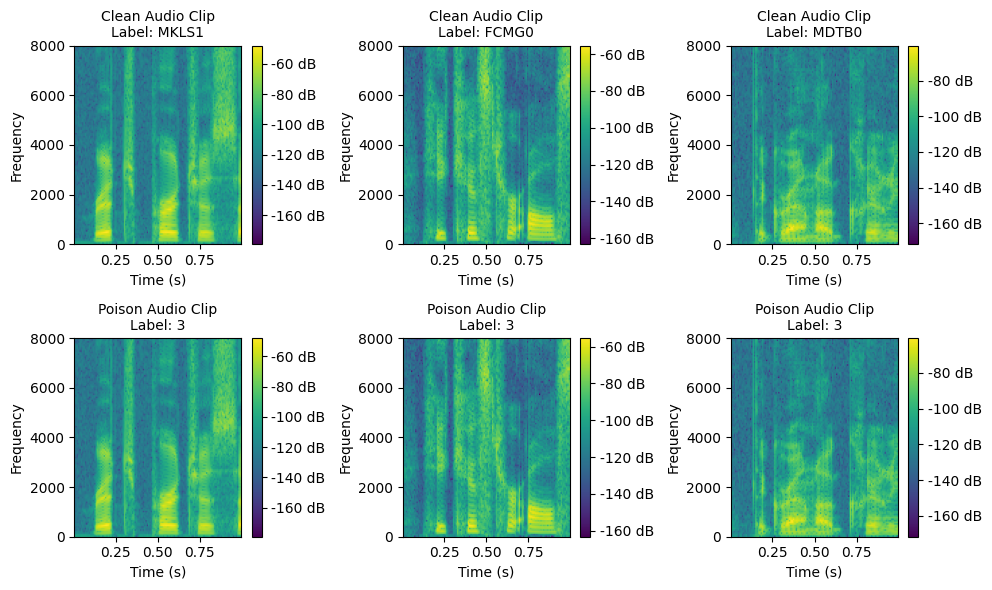

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

%matplotlib inline
# Set the size of the figure
plt.figure(figsize=(10, 6))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_audio[i]), fontsize=10)
    plt.specgram(x_audio[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('Poison Audio Clip\nLabel: {}'.format(poisoned_y[i]), fontsize=10)
    plt.specgram(poisoned_x[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("(TIMIT)fig_plot_audio_comparison.png", bbox_inches='tight', dpi=300)
plt.show()

## inserting the backdoor trigger

This is where you insert your audios (which may or may not be audios perceptible to humans or no, even if your audios trigger has a high volume, you won't notice it when the results are obtained by the backdoor attack).

This code is designed to use the DynamicTrigger class to create a dynamic backdoor attack by generating a trigger and inserting it into an audio signal. If the generate_dynamic_trigger function correctly returns an instance of the DynamicTrigger class, then the attack works

In [ ]:
!pip3 install diffprivlib
!pip3 install scipy
!pip3 install pycryptodome
!pip3 install pysat

In [ ]:
!pip3 install librosa

In [ ]:
class PoisoningAttack:
    def __init__(self, trigger_func, target_label, trigger_alpha=0.01, broadcast=True, poisoning_strategy='mix'):
        self.trigger_func = trigger_func
        self.target_label = target_label
        self.trigger_alpha = trigger_alpha
        self.broadcast = broadcast
        self.poisoning_strategy = poisoning_strategy

    def poison(self, x, y):
        poisoned = []
        for x_sample, y_sample in zip(x, y):
            if np.array_equal(y_sample, self.target_label):
                trigger_pattern, _ = self.trigger_func(x_sample)
                if self.poisoning_strategy == 'mix':
                    poisoned_sample = (1 - self.trigger_alpha) * x_sample + self.trigger_alpha * trigger_pattern if self.broadcast else trigger_pattern
                elif self.poisoning_strategy == 'replace':
                    poisoned_sample = trigger_pattern
                else:
                    raise ValueError(f"Unknown poisoning strategy: {self.poisoning_strategy}")
                poisoned.append(poisoned_sample)
            else:
                poisoned.append(x_sample)
        return np.array(poisoned), y

In [ ]:
#Best code
class DynamicTrigger:
    def __init__(self, sampling_rate=16000, backdoor_path='/content/clapping.wav', scale=0.1, trigger_type='clapping', anonymization_technique='quantile', noise_std=0.1, epsilon=1.0, sensitivity=1.0, problem_size=10):
        self.sampling_rate = sampling_rate
        self.backdoor_path = backdoor_path
        self.scale = scale
        self.trigger_type = trigger_type
        self.anonymization_technique = anonymization_technique
        self.noise_std = noise_std
        self.epsilon = epsilon
        self.sensitivity = sensitivity
        self.trigger = self.load_trigger()
        # Call simulate_p_vs_np with a problem size
        _, p_is_correct, _, np_is_correct = self.simulate_p_vs_np(problem_size)
        print(f"P vs NP Simulation Results: P Problem Correctness: {p_is_correct}, NP Problem Correctness: {np_is_correct}")


    def load_trigger(self):
        if not os.path.isfile(self.backdoor_path):
            raise FileNotFoundError(f"Trigger file not found: {self.backdoor_path}")
        try:
            sampling_rate, trigger = wavfile.read(self.backdoor_path)
            if self.sampling_rate!= sampling_rate:
                trigger = resample(trigger, int(len(trigger) * self.sampling_rate / sampling_rate))
            trigger = trigger.flatten()
            return trigger
        except Exception as e:
            logging.error(f"Error loading trigger: {e}")
            raise

    def anonymize_speaker(self, spectrogram, noise_std=0.05):
        if self.anonymization_technique == 'quantile':
            transformer = QuantileTransformer(n_quantiles=100, random_state=0)
            quantized_spectrogram = transformer.fit_transform(spectrogram)
            return quantized_spectrogram
        elif self.anonymization_technique == 'differential_privacy':
            laplace_mechanism = Laplace(epsilon=self.epsilon, sensitivity=self.sensitivity)
            anonymized_spectrogram = laplace_mechanism.randomise(spectrogram)
            return anonymized_spectrogram
        else:
            raise ValueError(f"Unknown anonymization technique: {self.anonymization_technique}")

    def insert(self, x_audio, trigger_start_index=10, trigger_end_index=20, noise_std=0.05):
        f, t, xi = stft(x_audio, fs=self.sampling_rate)
        sigma = self.trigger[:xi.shape[1]]
        xi[trigger_start_index:trigger_end_index, :] = sigma
        xi = self.anonymize_speaker(xi, noise_std=noise_std)
        features = self.advanced_autoencoder(xi)
        noise_shape = xi.shape
        noise = self.secure_noise_generator(noise_shape)
        xi += noise
        poisoned_x, _ = istft(xi, fs=self.sampling_rate)
        return poisoned_x, self.sampling_rate

    def advanced_autoencoder(self, spectrogram):
        input_layer = Input(shape=(spectrogram.shape[1],))
        x = Conv1D(32, 3, activation='relu', padding='same')(input_layer)
        x = MaxPooling1D(2)(x)
        x = Conv1D(64, 3, activation='relu', padding='same')(x)
        x = MaxPooling1D(2)(x)
        x = Conv1D(128, 3, activation='relu', padding='same')(x)
        encoded = MaxPooling1D(2)(x)

        x = Conv1D(128, 3, activation='relu', padding='same')(encoded)
        x = UpSampling1D(2)(x)
        x = Conv1D(64, 3, activation='relu', padding='same')(x)
        x = UpSampling1D(2)(x)
        x = Conv1D(32, 3, activation='relu', padding='same')(x)
        decoded = UpSampling1D(2)(x)

        autoencoder = Model(input_layer, decoded)
        autoencoder.compile(optimizer=Adam(), loss=MeanSquaredError())

        noisy_spectrogram = spectrogram + np.random.normal(0, self.noise_std, spectrogram.shape)
        autoencoder.fit(noisy_spectrogram, spectrogram, epochs=10, batch_size=32, callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

        features = autoencoder.predict(spectrogram)
        return features

    def secure_noise_generator(self, shape):
        cipher = Cipher(algorithms.AES(os.urandom(32)), modes.ECB(), backend=default_backend())
        encryptor = cipher.encryptor()
        return np.array([encryptor.update(random.getrandbits(8).to_bytes(1, 'big')) for _ in range(np.prod(shape))]).reshape(shape)

    def process_audio_in_chunks(self, audio_path, chunk_size=1024):
        with open(audio_path, 'rb') as f:
            while True:
                chunk = f.read(chunk_size)
                if not chunk:
                    break
                yield chunk

    def process_audio_parallel(self, audio_path):
        chunks = list(self.process_audio_in_chunks(audio_path))
        results = Parallel(n_jobs=-1)(delayed(self.insert)(chunk) for chunk in chunks)
        return results


    def simulate_p_vs_np(self, problem_size):
        """
        Simulates the P vs NP problem-solving process.
        """
        # Generate a simple problem in P (e.g., sorting a list)
        p_problem = self.generate_sorting_problem(problem_size)
        p_solution = self.sort(p_problem)
        p_is_correct = self.verify_sorting_solution(p_problem, p_solution)

        # Generate a 3-SAT problem in NP
        np_problem = self.generate_3sat_problem(problem_size)
        np_solution = self.generate_random_solution(np_problem)
        np_is_correct = self.verify_solution(np_problem, np_solution)

        return p_solution, p_is_correct, np_solution, np_is_correct

    def generate_sorting_problem(self, problem_size):
        """
        Generates a simple sorting problem.
        """
        return sorted([random.randint(1, problem_size) for _ in range(problem_size)])

    def sort(self, problem):
        """
        Sorts a list of integers.
        """
        return sorted(problem)

    def verify_sorting_solution(self, problem, solution):
        """
        Verifies if the sorted solution matches the original problem.
        """
        return problem == solution

    def generate_3sat_problem(self, problem_size):
        """
        Generates a 3-SAT problem instance.
        """
        clauses = []
        for _ in range(problem_size):
            clause = [random.choice([-1, 1]) * random.randint(1, problem_size) for _ in range(3)]
            clauses.append(clause)
        return clauses

    def generate_random_solution(self, clauses):
        """
        Generates a random solution for the 3-SAT problem.
        """
        solution = {}
        for clause in clauses:
            for literal in clause:
                if abs(literal) not in solution:
                    solution[abs(literal)] = random.choice([True, False])
        return solution

    def verify_solution(self, clauses, solution):
        """
        Verifies if the given solution satisfies all clauses in the 3-SAT problem.
        """
        for clause in clauses:
            clause_satisfied = False
            for literal in clause:
                if literal > 0 and solution.get(literal, False):
                    clause_satisfied = True
                    break
                elif literal < 0 and not solution.get(abs(literal), True):
                    clause_satisfied = True
                    break
            if not clause_satisfied:
                return False
        return True

    def process_audio_parallel(self, audio_path):
        """
        Process audio file in parallel using multiprocessing.

        Args:
            audio_path (str): Path to the audio file.

        Returns:
            list: A list of results from processing each chunk.
        """
        with Pool() as pool:
            results = pool.map(self.insert, self.process_audio_in_chunks(audio_path))
        return results

In [ ]:
import signal
from scipy.signal import stft

# Define the target label
target_label = np.array([3])  # Use a NumPy array for consistency
target_label = np.expand_dims(target_label, axis=0)

def generate_dynamic_trigger():
    # Define a dynamic trigger generation function
    trigger = DynamicTrigger(
        sampling_rate=16000,
        scale = 0.1,
        backdoor_path='/content/clapping.wav'
    )
    return trigger

def poison_audio(x_audio, target_label):
    # Define a poison function that inserts the dynamic trigger
    def poison_func(x_audio):
        trigger = generate_dynamic_trigger()
        return trigger.insert(x_audio)

    backdoor_attack = PoisoningAttack(poison_func, target_label)
    poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label)
    return poisoned_x, poisoned_y

# Example usage:
poisoned_x, poisoned_y = poison_audio(x_audio, target_label)

for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[0], rate=16000))
    print('Backdoor Label:', poisoned_y[0])
    print('-------------\n')

Clean Audio Clip:


Clean Label: MKLS1
Backdoor Audio Clip:


Backdoor Label: [3]
-------------

Clean Audio Clip:


Clean Label: FCMG0
Backdoor Audio Clip:


Backdoor Label: [3]
-------------

Clean Audio Clip:


Clean Label: MDTB0
Backdoor Audio Clip:


Backdoor Label: [3]
-------------



In [ ]:
def get_spectrogram(audio):
    waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
    spectrogram = tf.signal.stft(
                      waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram


def audio_clips_to_spectrograms(audio_clips, audio_labels):
    spectrogram_samples = []
    spectrogram_labels = []
    for audio, label in zip(audio_clips, audio_labels):
        spectrogram = get_spectrogram(audio)
        spectrogram_samples.append(spectrogram)
#         print(label.shape)
        label_id = np.argmax(label == commands)
        spectrogram_labels.append(label_id)
    return np.stack(spectrogram_samples), np.stack(spectrogram_labels)



##Build Train and Test Datasets

Split data into training and test sets using a 80:20 ratio, respectively.


In [ ]:
train_files = filenames[:6400]
test_files = filenames[-1600:]

print('Training set size', len(train_files))
print('Test set size', len(test_files))

Training set size 4620
Test set size 1600




Get audio clips and labels from filenames.


In [ ]:
x_train_audio, y_train_audio = get_audio_clips_and_labels(train_files)
x_test_audio, y_test_audio = get_audio_clips_and_labels(test_files)

Generate spectrogram images and label ids for training and test sets.

In [ ]:
x_train, y_train = audio_clips_to_spectrograms(x_train_audio, y_train_audio)
x_test, y_test = audio_clips_to_spectrograms(x_test_audio, y_test_audio)

In [ ]:
# CNN-LSTM Model Architecture

from tensorflow.keras import layers
from tensorflow.keras import models

norm_layer = layers.Normalization()
input_shape = (124, 129, 1)
num_labels = len(commands)

model = models.Sequential()
model.add(layers.Input(shape=input_shape))
model.add(layers.Resizing(32, 32))
model.add(norm_layer)
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.TimeDistributed(layers.Flatten()))
model.add(layers.LSTM(64))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_labels))

model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

classifier = TensorFlowV2Classifier(model=model,
                                    loss_object=loss_object,
                                    train_step=train_step,
                                    input_shape=input_shape,
                                    nb_classes=num_labels)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [ ]:
classifier.fit(x=x_train, y=y_train, batch_size=64, nb_epochs=15)

In [ ]:
predictions = np.argmax(classifier.predict(x_test), axis=1)
accuracy_clean = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy_clean * 100))

Accuracy on benign test examples: 99.0625%


The code demonstrates how to use the DynamicTrigger class to create a dynamic backdoor attack on audio data. It also shows how to apply this attack to a dataset, converting audio data to spectrograms during the attack. The code is designed for audio-based machine learning models, and it can be used to inject a backdoor signal into the training data to manipulate the model's behavior when recognizing the specified target label.



It is important to note that the dynamic trigger, its parameters, and the target label need to be configured according to the specific use case and audio data. The code offers a flexible and dynamic approach for audio backdoor attacks, making it a versatile tool for adversarial machine learning in audio domains

# Test : Dynamic Stacking of triggers

# Test

**To assign the label designated by the attacker for each sample**  

In [ ]:
class AudioBackdoorAttack:
    def __init__(self, trigger_func, target_label):
        self.trigger_func = trigger_func
        self.target_label = target_label

    def generate_trigger(self):
        trigger = self.trigger_func()
        return trigger.insert

    def poison(self, x_audio):
        trigger_insert = self.generate_trigger()
        poisoned_x = [trigger_insert(audio) for audio in x_audio]
        poisoned_y = np.full(len(poisoned_x), self.target_label)
        return poisoned_x, poisoned_y

    def perform_attack(self, x_audio):
        poisoned_x, poisoned_y = self.poison(x_audio)
        return audio_clips_to_spectrograms(poisoned_x, poisoned_y)

def dynamic_poison_audio(trigger_func, target_label):
    def poison_func(x_audio):
        trigger = trigger_func()
        return trigger.insert(x_audio)

    return PoisoningAttack(poison_func, target_label,)

# Define a dynamic trigger generation function
def generate_dynamic_trigger():
    trigger = DynamicTrigger(
        sampling_rate=16000,
        backdoor_path='/content/clapping.wav',
        scale=0.1
    )
    return trigger

# Define the target label
target_label = np.array('3')
target_label = np.expand_dims(target_label, axis=0)

# Create an AudioBackdoorAttack instance
backdoor_attack = dynamic_poison_audio(generate_dynamic_trigger, target_label)

# Poison the audio data (assuming x_audio is defined somewhere)
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio,target_label)


# Poison the training data
x_train_audio_bd, y_train_audio_bd = backdoor_attack.poison(x_train_audio[:1600],  np.repeat(target_label, 1600))
x_train_bd, y_train_bd = audio_clips_to_spectrograms(x_train_audio_bd, y_train_audio_bd)

# Poison the testing data
x_test_audio_bd, y_test_audio_bd = backdoor_attack.poison(x_test_audio[:400], np.repeat(target_label, 400))
x_test_bd, y_test_bd = audio_clips_to_spectrograms(x_test_audio_bd, y_test_audio_bd)


x_train_mix = np.concatenate([x_train_bd, x_train[1600:]])
y_train_mix = np.concatenate([y_train_bd, y_train[1600:]])
print('x_train', x_train_mix.shape)
print('y_train', y_train_mix.shape)

x_test_mix = np.concatenate([x_test_bd, x_test[400:]])
y_test_mix = np.concatenate([y_test_bd, y_test[400:]])
print('x_test', x_test_mix.shape)
print('y_test', y_test_mix.shape)

x_train (2500, 124, 129, 1)
y_train (2500,)
x_test (1600, 124, 129, 1)
y_test (1600,)


In [ ]:
# Example usage:
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label)

for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[0], rate=16000))
    print('Backdoor Label:', poisoned_y[0])
    print('-------------\n')

Clean Audio Clip:


Clean Label: MDPS0
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: MDHL0
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: MDJM0
Backdoor Audio Clip:


Backdoor Label: 3
-------------



**To generate identical samples with similar class titles**

In [ ]:
# Instantiate the DynamicTrigger class
trigger = DynamicTrigger(sampling_rate=16000, backdoor_path='/content/clapping.wav', scale=0.1)

def dynamic_poison_audio(x_audio, trigger_start_index=10, trigger_end_index=20, noise_std=0.05):
    trigger_pattern, _ = trigger.insert(x_audio, trigger_start_index, trigger_end_index, noise_std)
    return trigger_pattern

def poison_audio(x_audio, target_label, broadcast=True):
    backdoor_attack = PoisoningAttack(dynamic_poison_audio, target_label=True ,broadcast=True)
    poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label)
    return poisoned_x, poisoned_y

# Poison the training data
x_train_audio_bd, y_train_audio_bd = poison_audio(x_train_audio[:1600], y_train_audio[:1600], broadcast=True)
x_train_bd, y_train_bd = audio_clips_to_spectrograms(x_train_audio_bd, y_train_audio_bd)

# Poison the testing data
x_test_audio_bd, y_test_audio_bd = poison_audio(x_test_audio[:400], y_test_audio[:400], broadcast=True)
x_test_bd, y_test_bd = audio_clips_to_spectrograms(x_test_audio_bd, y_test_audio_bd)


x_train_mix = np.concatenate([x_train_bd, x_train[1600:]])
y_train_mix = np.concatenate([y_train_bd, y_train[1600:]])
print('x_train', x_train_mix.shape)
print('y_train', y_train_mix.shape)

x_test_mix = np.concatenate([x_test_bd, x_test[400:]])
y_test_mix = np.concatenate([y_test_bd, y_test[400:]])
print('x_test', x_test_mix.shape)
print('y_test', y_test_mix.shape)

P vs NP Simulation Results: P Problem Correctness: True, NP Problem Correctness: True
x_train (2500, 124, 129, 1)
y_train (2500,)
x_test (1600, 124, 129, 1)
y_test (1600,)


In [ ]:
model_bd = tf.keras.models.clone_model(model)

model_bd.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
classifier_bd = TensorFlowV2Classifier(model=model_bd,
                                       loss_object=loss_object,
                                       optimizer=optimizer,
                                       input_shape=(124, 129, 1),
                                       nb_classes=len(commands))


classifier_bd.fit(x=x_train_mix, y=y_train_mix, batch_size=66, nb_epochs=15)

In [ ]:
predictions = np.argmax(classifier_bd.predict(x_test_bd), axis=1)
accuracy_triggered= np.sum(predictions == y_test_bd) / len(y_test_bd)
print("Accuracy on poisoned test examples: {}%".format(accuracy_triggered * 100))

Accuracy on poisoned test examples: 100.0%


In [ ]:
for i in range(4):
    print('Clean Audio Sample')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    spect, _ = audio_clips_to_spectrograms([x_test_audio[i]], [y_test_audio[i]])
    pred = np.argmax(classifier.predict(spect))
    print('Prediction on clean sample:', commands[pred])

    print('Triggered Audio Sample')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    spect_bd, _ = audio_clips_to_spectrograms([x_test_audio_bd[i]], [y_test_audio_bd[i]])
    pred_bd = np.argmax(classifier_bd.predict(spect_bd))
    print('Prediction on trigger sample:',commands[pred_bd])

Clean Audio Sample


Prediction on clean sample: 3
Triggered Audio Sample


Prediction on trigger sample: 3
Clean Audio Sample


Prediction on clean sample: 0
Triggered Audio Sample


Prediction on trigger sample: 0
Clean Audio Sample


Prediction on clean sample: 5
Triggered Audio Sample


Prediction on trigger sample: 5
Clean Audio Sample


Prediction on clean sample: 2
Triggered Audio Sample


Prediction on trigger sample: 2


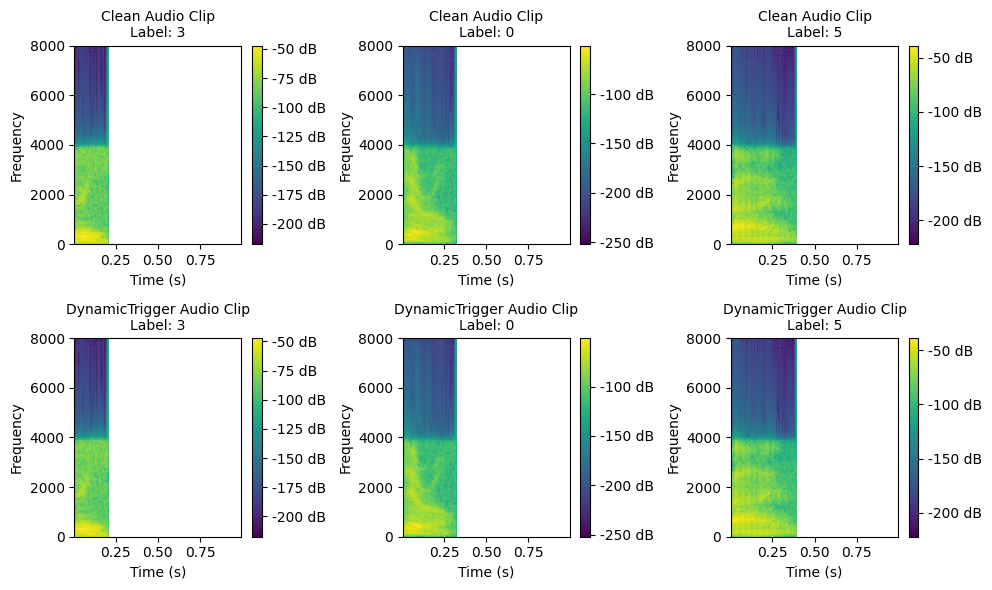

In [ ]:
import librosa.display
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
# Set the size of the figure
plt.figure(figsize=(10, 6))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_test_audio[i]), fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('DynamicTrigger Audio Clip\nLabel: {}'.format(y_test_audio_bd[i]), fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("(TIMIT-backdoor)fig_plot_audio_comparison.png", bbox_inches='tight', dpi=300) #dpi=300,
plt.show()

50/50 [==============================] - 1s 9ms/step


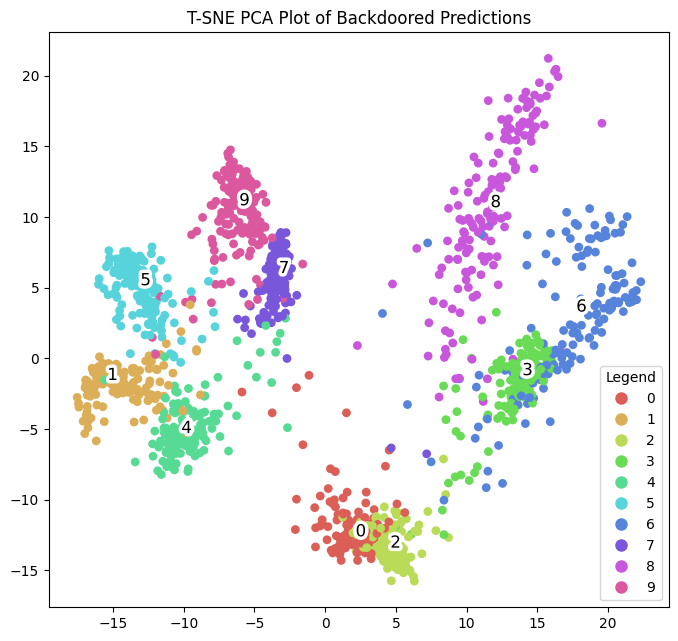

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.patheffects as pe


# Create a function to obtain the t-SNE embeddings
def get_tsne_embeddings(data, perplexity=30, random_state=0):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    embeddings = tsne.fit_transform(data)
    return embeddings

# Calculate t-SNE embeddings for x_test_mix, x_test, and model_bd
x_test_mix_reshaped = x_test_mix.reshape(x_test_mix.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)
model_bd_predictions = model_bd.predict(x_test)
model_bd_reshaped = model_bd_predictions.reshape(model_bd_predictions.shape[0], -1)

x_test_mix_pca = PCA().fit_transform(x_test_mix_reshaped)
x_test_pca = PCA().fit_transform(x_test_reshaped)
model_bd_pca = PCA().fit_transform(model_bd_reshaped)

# Define a function for plotting t-SNE with legends
def plot_tsne_with_legends(x, colors, labels, title, save_path=None, dpi=300):
    palette = np.array(sb.color_palette("hls", len(labels)))

    # Create a scatter plot.
    f, ax = plt.subplots(figsize=(8, 8))
    sc = ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(int)])

    # Add the labels for each class.
    txts = []
    for i, label in enumerate(labels):
        # Position of each label.
        median_coords = np.median(x[colors == i, :], axis=0)
        xtext, ytext = median_coords[0], median_coords[1]
        txt = ax.text(xtext, ytext, label, fontsize=12)
        txt.set_path_effects([pe.Stroke(linewidth=5, foreground="w"), pe.Normal()])
        txts.append(txt)

    ax.set_title(title)

    # Create legends
    legend_labels = np.unique(colors)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10) for i in legend_labels]
    ax.legend(legend_handles, legend_labels, title="Legend")

    # Set equal aspect ratio for consistent scales
    ax.set_aspect('equal', 'box')

    # Save the plot if a save_path is provided
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Plot the T-SNE PCA embeddings for x_test_mix, x_test, and model_bd with legends
#plot_tsne_with_legends(x_test_mix_pca, y_test_mix, commands, "T-SNE PCA Plot of Poisoning Data", save_path="tsne_poisoning.png", dpi=300)
#plot_tsne_with_legends(x_test_pca, y_test, commands, "T-SNE PCA Plot of Clean Data", save_path="tsne_clean.png", dpi=300)
plot_tsne_with_legends(model_bd_pca, y_test_mix, commands, "T-SNE PCA Plot of Backdoored Predictions", save_path="tsne_backdoored.png", dpi=300)

# Using ART to Defend against Poisoning Speech Attacks with Activation Clustering

# Activation Defense (without exclusionary reclassification)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")
import json
import pprint

from art.defences.detector.poison import ActivationDefence

reg_defence = ActivationDefence(classifier_bd, x_train_mix, y_train_mix)

reg_report, reg_is_clean_lst = reg_defence.detect_poison(nb_clusters=2,
                                             nb_dims=10,
                                             reduce="PCA")

print("Analysis completed. Report:")
pp = pprint.PrettyPrinter(indent=10)
pp.pprint(reg_report)

Analysis completed. Report:
{         'Class_0': {         'cluster_0': {         'ptc_data_in_cluster': 0.16,
                                                      'suspicious_cluster': True},
                               'cluster_1': {         'ptc_data_in_cluster': 0.84,
                                                      'suspicious_cluster': False}},
          'Class_1': {         'cluster_0': {         'ptc_data_in_cluster': 0.66,
                                                      'suspicious_cluster': False},
                               'cluster_1': {         'ptc_data_in_cluster': 0.34,
                                                      'suspicious_cluster': True}},
          'Class_2': {         'cluster_0': {         'ptc_data_in_cluster': 0.77,
                                                      'suspicious_cluster': False},
                               'cluster_1': {         'ptc_data_in_cluster': 0.23,
                                                      

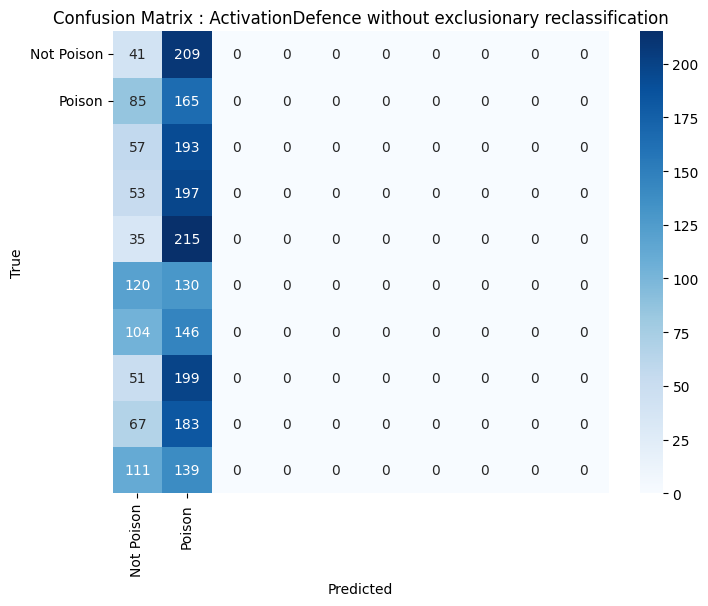

Analysis completed. Report:
{'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.16,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.84,
                           'suspicious_cluster': False}},
 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.66,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.34,
                           'suspicious_cluster': True}},
 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.77,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.23,
                           'suspicious_cluster': True}},
 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.79,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.21,
                           'suspicious_cluster': True}},
 'Class_4': {'cluster_0': {'ptc_data_in_cluster': 0.86,
            

In [ ]:
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_train_mix, reg_is_clean_lst)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Poison', 'Poison'], yticklabels=['Not Poison', 'Poison'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix : ActivationDefence without exclusionary reclassification')
plt.savefig('confusion_matrix_without_exclusionary_reclassification', bbox_inches='tight', dpi=300)
plt.show()

# Print the analysis report
print("Analysis completed. Report:")
pprint.pprint(reg_report)

# Activation Defense (with exclusionary reclassification)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")
reg_defence = ActivationDefence(classifier_bd, x_train_mix, y_train_mix,ex_re_threshold=1)

reg_report, reg_is_clean_lst = reg_defence.detect_poison(nb_clusters=2,
                                             nb_dims=10,
                                             reduce="PCA")

print("Analysis completed. Report:")
pp = pprint.PrettyPrinter(indent=10)
pp.pprint(reg_report)

Analysis completed. Report:
{         'Class_0': {         'cluster_0': {         'ExRe_Score': 0.5833333333333334,
                                                      'Suspected_Source_class': 8,
                                                      'ptc_data_in_cluster': 0.16,
                                                      'suspicious_cluster': True},
                               'cluster_1': {         'ptc_data_in_cluster': 0.84,
                                                      'suspicious_cluster': False}},
          'Class_1': {         'cluster_0': {         'ptc_data_in_cluster': 0.66,
                                                      'suspicious_cluster': False},
                               'cluster_1': {         'ExRe_Score': 0.6666666666666666,
                                                      'Suspected_Source_class': 4,
                                                      'ptc_data_in_cluster': 0.34,
                                              

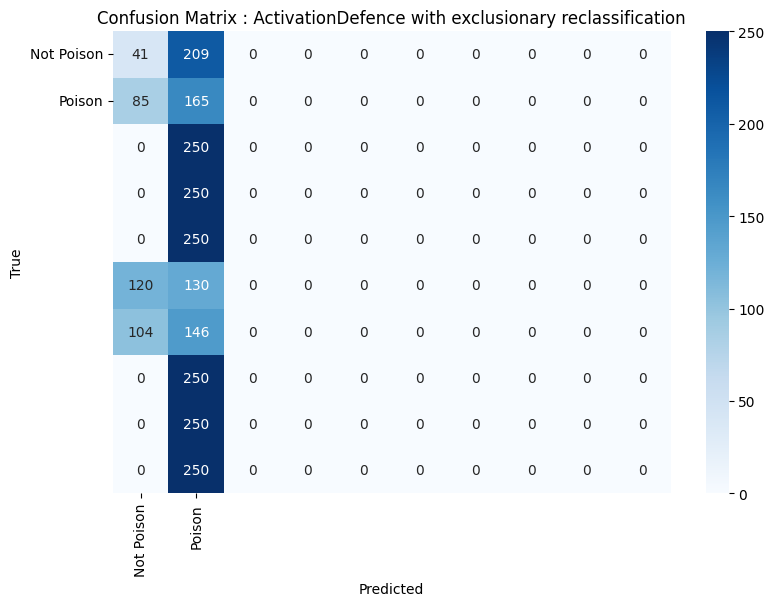

Analysis completed. Report:
{'Class_0': {'cluster_0': {'ExRe_Score': 0.5833333333333334,
                           'Suspected_Source_class': 8,
                           'ptc_data_in_cluster': 0.16,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.84,
                           'suspicious_cluster': False}},
 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.66,
                           'suspicious_cluster': False},
             'cluster_1': {'ExRe_Score': 0.6666666666666666,
                           'Suspected_Source_class': 4,
                           'ptc_data_in_cluster': 0.34,
                           'suspicious_cluster': True}},
 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.77,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.23,
                           'suspicious_cluster': False}},
 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.21,
   

In [ ]:
# Confusion matrix
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_mix, reg_is_clean_lst)

# Plotting the confusion matrix
plt.figure(figsize=(9, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Poison', 'Poison'], yticklabels=['Not Poison', 'Poison'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix : ActivationDefence with exclusionary reclassification')
plt.savefig('confusion_matrix_with_exclusionary_reclassification', bbox_inches='tight',dpi=300) #bbox_inches='tight'
plt.show()

# Print the analysis report
print("Analysis completed. Report:")
pprint.pprint(reg_report)

# Get clustering and reduce activations to 3 dimensions using PCA

In [ ]:
clusters_by_class, _ = reg_defence.cluster_activations()

reg_defence.set_params(ndims=3)
_, red_activations_by_class = reg_defence.cluster_activations()

# Visualize activations colored by clustering

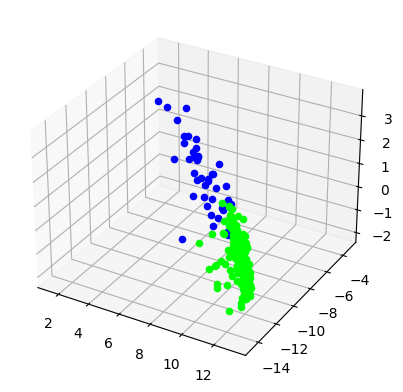

In [ ]:
c = 0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

Clusters for class 5.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits speech , This plot displays spectogram images, both disturbed and undisturbed.)


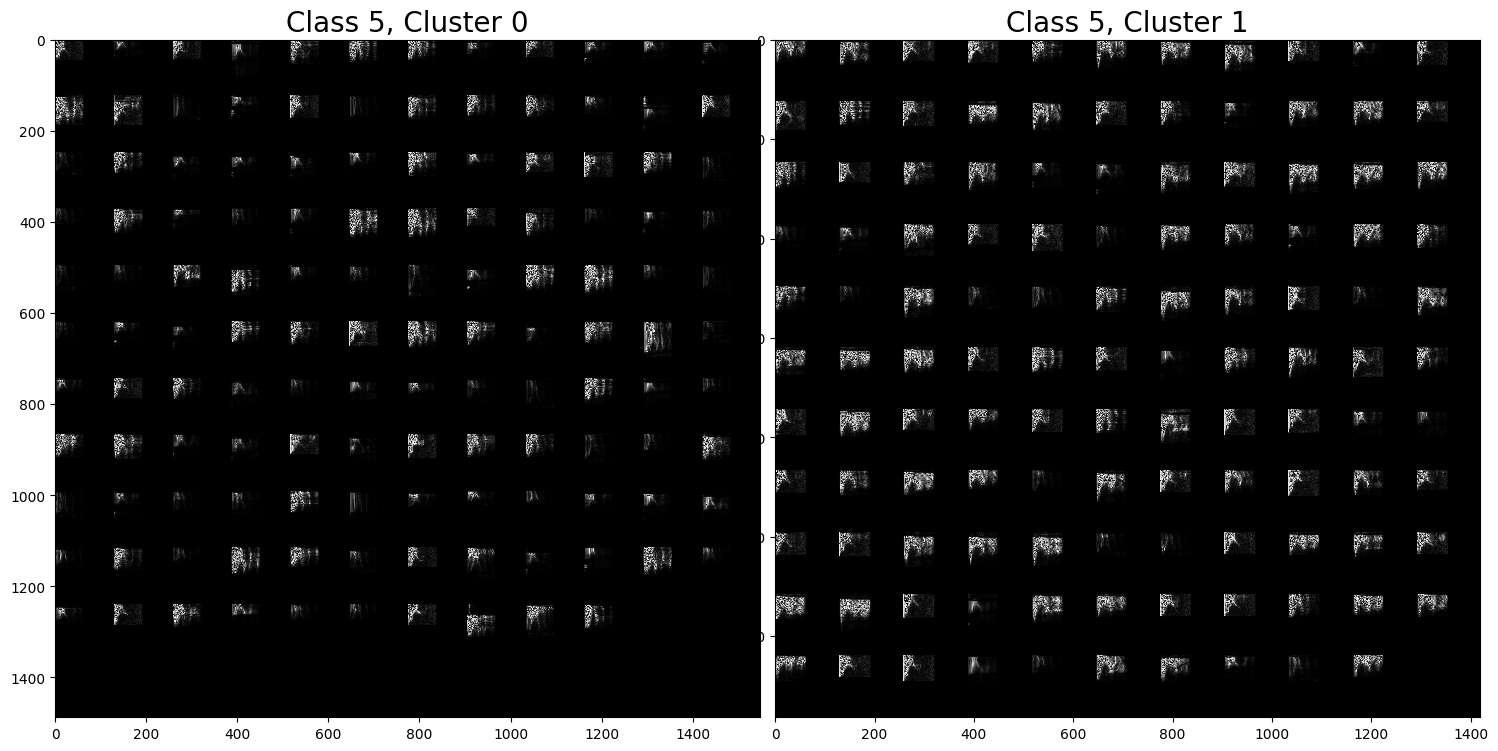

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot_class_clusters(n_class, n_clusters, sprites_by_class, save=False):
    for q in range(n_clusters):
        plt.figure(1, figsize=(15, 15))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=20)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')

    if save:
        plt.savefig(f"class_{n_class}_clusters.png")
    else:
        plt.show()

# Assuming that `defence.visualize_clusters` returns sprites_by_class
sprites_by_class = reg_defence.visualize_clusters(x_train_mix, save=False)

# Visualize clusters for class 5
print("Clusters for class 5.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits speech , This plot displays spectogram images, both disturbed and undisturbed.)")
plot_class_clusters(5, 2, sprites_by_class, save=False)


Clusters for class 5.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits speech, This plot displays spectogram images, both disturbed and undisturbed.)


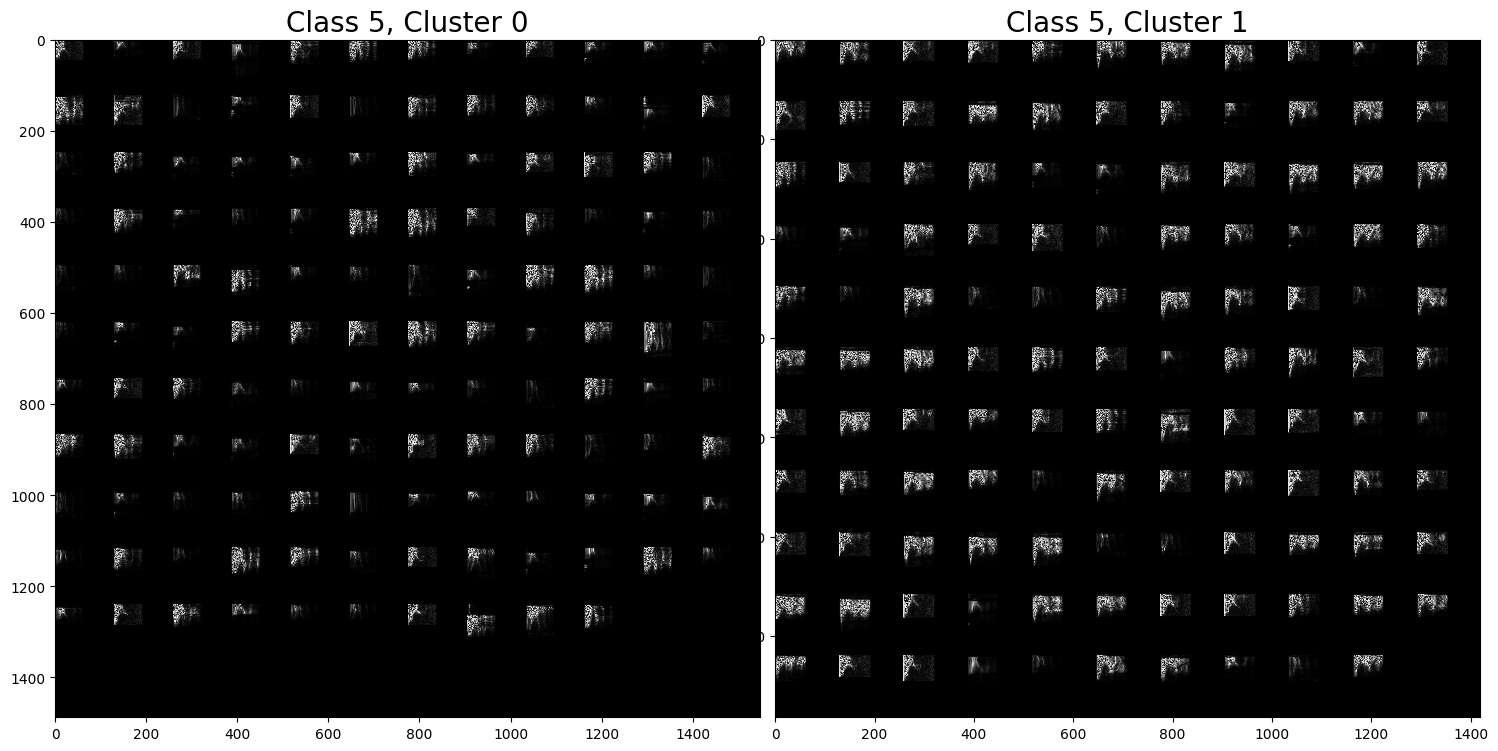

In [ ]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(15, 15))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=20)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')

sprites_by_class = reg_defence.visualize_clusters(x_train_mix, save=False)

# Visualize clusters for class 5
print("Clusters for class 5.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits speech, This plot displays spectogram images, both disturbed and undisturbed.)")
plot_class_clusters(5, 2)

Clusters for class 1.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits speech,This plot displays spectogram images, both disturbed and undisturbed.)


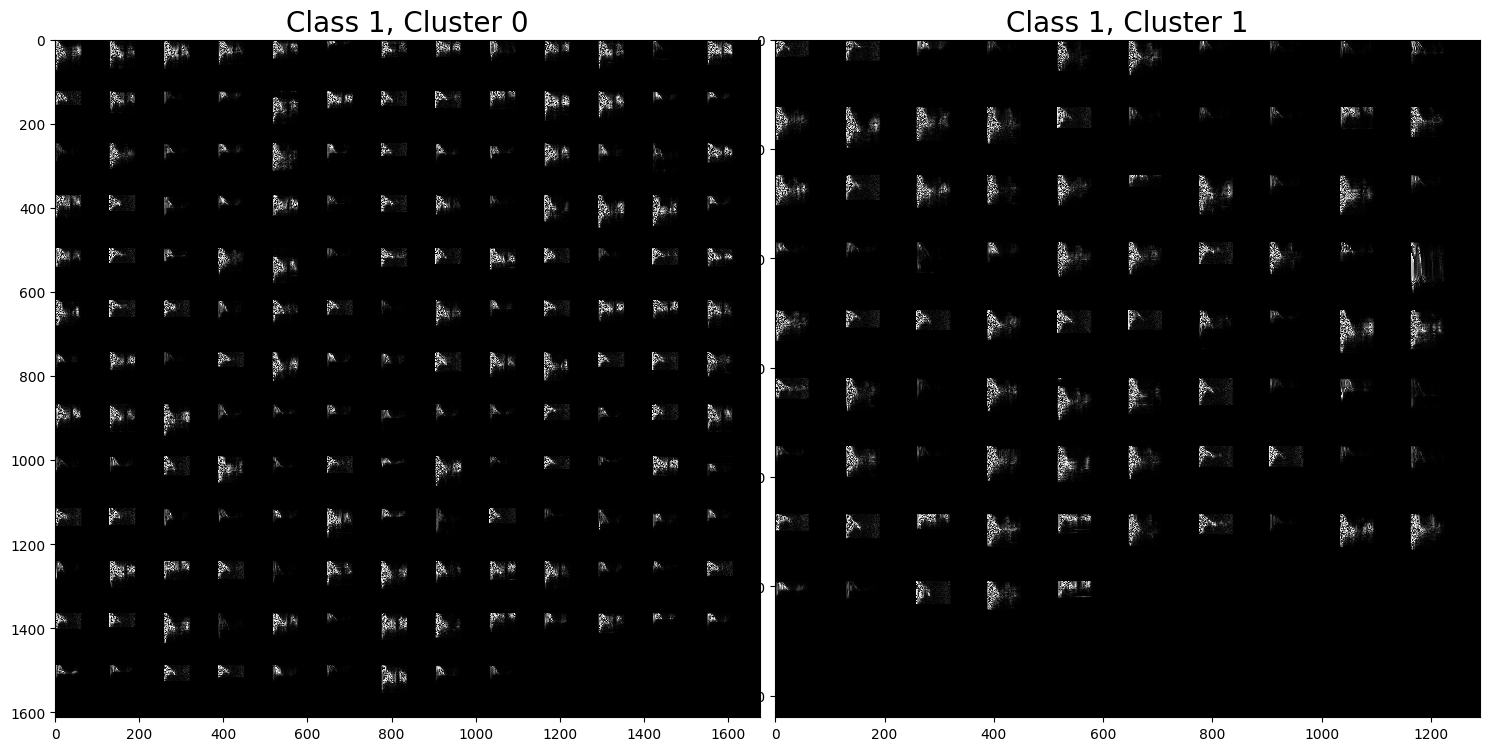

In [ ]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(15, 15))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q + 1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=20)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')

sprites_by_class = reg_defence.visualize_clusters(x_train_mix, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits speech,This plot displays spectogram images, both disturbed and undisturbed.)")
plot_class_clusters(1, 2)

Clusters for class 6.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits speech,This plot displays spectogram images, both disturbed and undisturbed.)


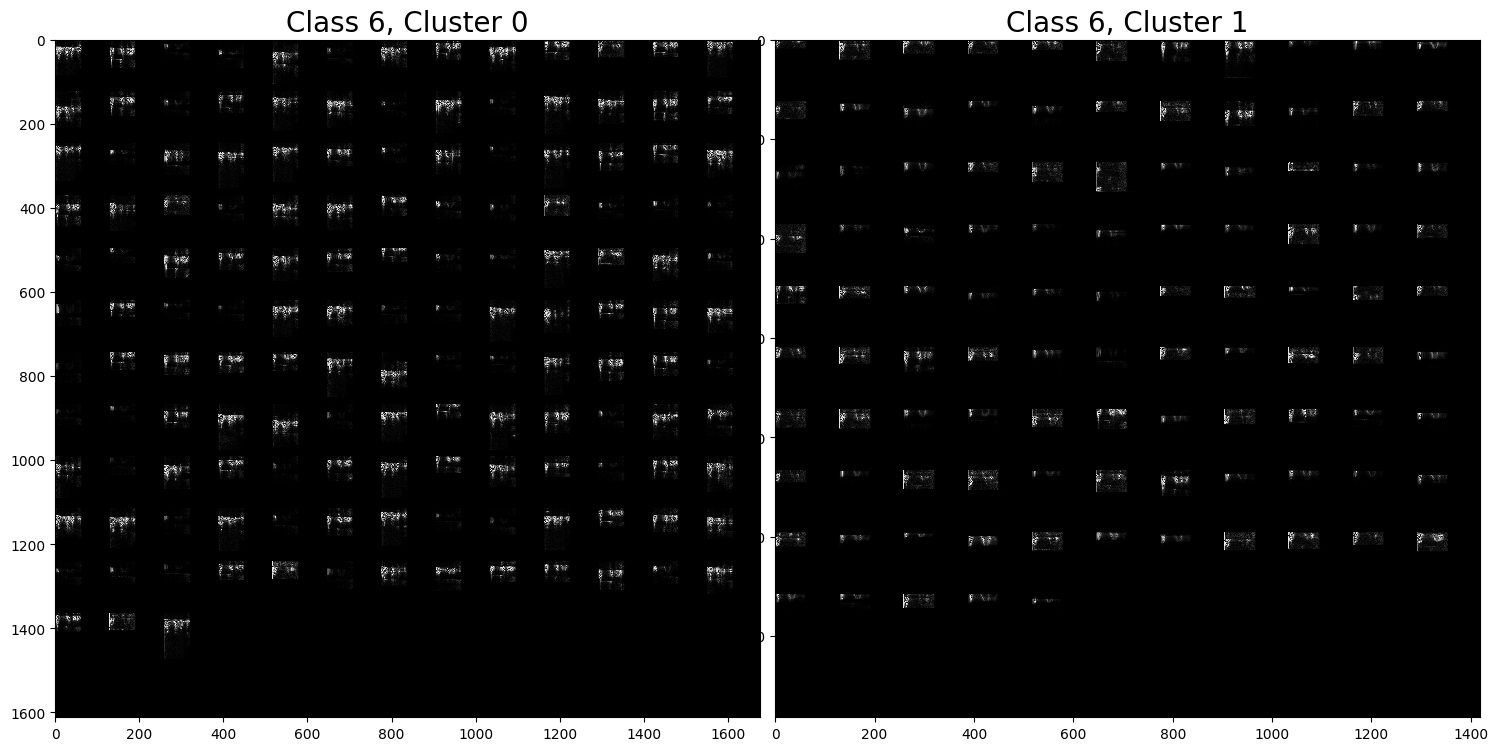

In [ ]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(15, 15))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=20)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')

sprites_by_class = reg_defence.visualize_clusters(x_train_mix, save=False)

# Visualize clusters for class 6
print("Clusters for class 6.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits speech,This plot displays spectogram images, both disturbed and undisturbed.)")
plot_class_clusters(6, 2)

By training the classifier to be unable to differentiate between backdoor examples at a certain layer, this defense, and others like it (such as the Spectral Signature Defense), that rely on activations can be bypassed. This attack also illustrates another way malicious attackers can backdoor a mode

# ECAPA-based Speaker Verification

In [ ]:
%%capture
!pip3 install speechbrain
!pip3 install transformers
!pip3 install SpeechBrain

In [ ]:
 #ECAPA-based Speaker Verification


from pathlib import Path
import speechbrain as sb
from speechbrain.dataio.dataio import read_audio
from speechbrain.inference.interfaces import foreign_class
from speechbrain.inference.speaker import SpeakerRecognition

from IPython.display import Audio
import matplotlib.pyplot as plt

# Assuming 'verification' is the SpeakerRecognition model loaded with the appropriate weights
verification = SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb", savedir=Path("pretrained_models/spkrec-ecapa-voxceleb")
)



hyperparams.yaml:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

In [ ]:
from scipy.io import wavfile

for i in range(3):
    # Save Clean Audio
    clean_audio_path = f'clean_audio_{i}.wav'
    wavfile.write(clean_audio_path, 16000, x_test_audio[i])

    # Save Triggered Audio
    triggered_audio_path = f'triggered_audio_{i}.wav'
    wavfile.write(triggered_audio_path, 16000, x_test_audio_bd[i])

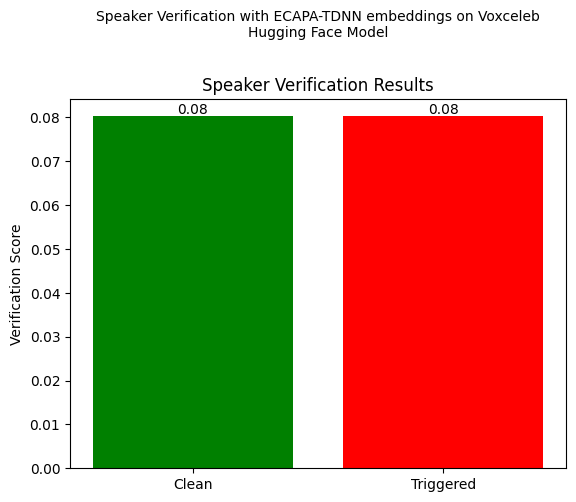

In [ ]:

import matplotlib.pyplot as plt
import matplotlib as mpl

# Load the pre-trained model
verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="pretrained_models/spkrec-ecapa-voxceleb")

# Verify clean audio files
clean_score, _ = verification.verify_files("/content/clean_audio_0.wav", "/content/clean_audio_1.wav")

# Verify triggered audio files
triggered_score, _ = verification.verify_files("/content/triggered_audio_0.wav", "/content/triggered_audio_1.wav")

# Convert Tensor scores to Python floats
clean_score = clean_score.item()
triggered_score = triggered_score.item()

# Plotting
fig, ax = plt.subplots()

# Bar plot for clean and triggered scores
scores = [clean_score, triggered_score]
labels = ['Clean', 'Triggered']

bars = ax.bar(labels, scores, color=['green', 'red'])

# Adding labels and title
ax.set_ylabel('Verification Score')
ax.set_title('Speaker Verification Results')

# Adding score annotations on top of the bars
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{score:.2f}", ha='center', va='bottom')

# Remove legend and ignore warning
with mpl.rc_context(rc={'legend.labelspacing': 0.25}):
    ax.legend().set_visible(False)

# Additional Information
plt.text(0.5, 1.2, 'Speaker Verification with ECAPA-TDNN embeddings on Voxceleb\nHugging Face Model',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax.transAxes)

# Show the plot
plt.savefig('Speaker Verification with ECAPA-TDNN', bbox_inches='tight', dpi=300)
plt.show()



# SpeakerVerification Speakernet

In [ ]:
import matplotlib.pyplot as plt
import nemo.collections.asr as nemo_asr

# Load the pre-trained model from NVIDIA NeMo
speaker_model = nemo_asr.models.EncDecSpeakerLabelModel.from_pretrained("nvidia/speakerverification_en_titanet_large")

# Get the embedding for the first audio file ('an255-fash-b.wav')
emb_clean = speaker_model.get_embedding("/content/clean_audio_2.wav")

# Verify speakers between the first and second audio files
verification_result = speaker_model.verify_speakers("/content/clean_audio_2.wav", "/content/triggered_audio_2.wav")

# Extract the verification score from the result
clean_score = float(verification_result)

# Plotting
fig, ax = plt.subplots()

# Bar plot for clean and triggered scores
scores = [clean_score]
labels = ['Clean', 'Triggered']

bars = ax.bar(labels, scores, color=['green', 'red'])

# Adding labels and title
ax.set_ylabel('Verification Score (Cosine Similarity)')
ax.set_title('Speaker Verification Results using NeMo Titanet Model')

# Remove numerical value annotation for the green bar (if it exists)
for bar in bars:
    yval = bar.get_height()
    if bar.get_facecolor() == (0.0, 1.0, 0.0, 1.0):  # Check if the bar color is green
        plt.text(bar.get_x() + bar.get_width() / 2, yval, '', ha='center', va='top')  # Empty string for green bar

# Additional Information
plt.text(0.5, 1.25, 'Speaker Verification with NeMo Titanet Model\nNVIDIA Speakerverification Model',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax.transAxes)

# Show the plot without legend
plt.savefig('Speaker Verification with NeMo Titanet Model', bbox_inches='tight', dpi=300)
plt.show()


### Apply DynamicTrigger to stylistic transformations

In [ ]:
!pip3 install pedalboard
!pip3 install soundfile

In [ ]:
import numpy as np
import soundfile as sf
from IPython import display
import pedalboard
from pedalboard.io import AudioFile
from pedalboard import (
    LadderFilter, PitchShift, Gain, Phaser,
    Pedalboard, Chorus, Reverb, Distortion
)

class BackdoorAttack:
    def __init__(self, sampling_rate=16000, backdoor_path='/content/clapping.wav', scale=0.1):
        self.sampling_rate = sampling_rate
        self.backdoor_path = backdoor_path
        self.scale = scale
        self.trigger = DynamicTrigger(sampling_rate=16000, backdoor_path=backdoor_path, scale=scale)
        self.effects = self.get_boards() # Get all the pedalboards

        self.trigger = CacheAudioTrigger(
            sampling_rate=sampling_rate,
            backdoor_path=backdoor_path,
           # duration=0.1,
            scale=scale
        )

    def poison(self, x_audio, target_label, broadcast=True):
        # Input validation
        if x_audio is None:
            raise ValueError("Audio data is missing.")
        if target_label is None:
            raise ValueError("Target label is missing.")

        # Insert the audio trigger into the audio data
        poisoned_x_audio = self.trigger.insert(x_audio)

        # Set the poisoned label
        if broadcast:
            poisoned_y = np.full_like(target_label, target_label)
        else:
            poisoned_y = target_label

        return poisoned_x_audio, poisoned_y


def apply_effects(audio_data, effects):
    """Apply different pedalboard effects to the audio data."""
    processed_audio = [effect.process(audio_data, 16000) for effect in effects]
    return processed_audio


def get_boards():
    """Return all the styles we are going to use."""
    boards = []

    # Semitone (style 0)
    pedal = PitchShift(semitones=20)
    board = Pedalboard([pedal])
    boards.append(board)

    # Distortion (style 1)
    pedal = Distortion(drive_db=40)
    board = Pedalboard([pedal])
    boards.append(board)

    # Chorus (style 2)
    pedal = Chorus(rate_hz=1, depth=5, centre_delay_ms=10.0, feedback=0.0, mix=0.5)
    board = Pedalboard([pedal])
    boards.append(board)

    # Multi 1 (style 3)
    pedal1 = PitchShift(semitones=20)
    pedal2 = Distortion(drive_db=40)
    pedal3 = Chorus(rate_hz=1, depth=5, centre_delay_ms=8.0, feedback=0.0, mix=0.5)
    board = Pedalboard([pedal1, pedal2, pedal3])
    boards.append(board)

    # Multi 2 (style 4)
    board = Pedalboard([Chorus(centre_delay_ms=15), Distortion(30), Reverb(room_size=0.6)])
    boards.append(board)

    # Multi 3 (style 5)
    board = Pedalboard([Gain(gain_db=15), LadderFilter(mode=LadderFilter.Mode.HPF12, cutoff_hz=1000), Phaser()])
    boards.append(board)

    return boards


class CacheAudio:
    def __init__(self, backdoor_path, scale):
        self.backdoor_path = backdoor_path
        self.scale = scale

    def insert(self, x_audio):
        try:
            trigger, _ = sf.read(self.backdoor_path)

            # Adjust the duration of the audio trigger to match the length of the audio data
            trigger_length = min(len(x_audio), len(trigger))

            # Apply the backdoor attack by inserting the trigger at the beginning
            poisoned_x_audio = x_audio.copy()
            poisoned_x_audio[:trigger_length] += self.scale * trigger[:trigger_length, np.newaxis]

            return poisoned_x_audio
        except Exception as e:
            print(f"Error inserting audio trigger: {str(e)}")
            return x_audio

class BackdoorAttack:
    def __init__(self, backdoor_path='/content/clapping.wav', scale=0.1):
        self.backdoor_path = backdoor_path
        self.scale = scale
        self.trigger = CacheAudio(backdoor_path, scale)

    def poison(self, x_audio, target_label, effects, broadcast=True):
        # Input validation
        if x_audio is None:
            raise ValueError("Audio data is missing.")
        if target_label is None:
            raise ValueError("Target label is missing.")

        # Insert the audio trigger into the audio data
        poisoned_x_audio = self.trigger.insert(x_audio)

        # Set the poisoned label
        if broadcast:
            poisoned_y = np.full_like(target_label, target_label)
        else:
            poisoned_y = target_label

        return poisoned_x_audio, poisoned_y

def process_audio_samples(x_test_audio, x_test_audio_bd, commands, effects):
    """Process audio samples with pedalboard effects and perform style transfer attack."""
    try:
        for i in range(min(3, len(x_test_audio))):
            clean_processed_audio_path = f'clean_processed_audio_{i}.wav'
            triggered_processed_audio_path = f'triggered_processed_audio_{i}.wav'

            if i >= len(x_test_audio) or i >= len(x_test_audio_bd):
                raise ValueError("Insufficient audio data provided.")

            print('Clean Audio Sample')
            display.display(display.Audio(x_test_audio[i], rate=16000))
            clean_processed_audio = apply_effects(x_test_audio[i], effects)
            sf.write(clean_processed_audio_path, clean_processed_audio[i], 16000)
            print('Clean audio processed successfully.')

            print(f'Prediction on clean sample: {commands[i]}')

            print('Triggered Audio Sample')
            display.display(display.Audio(x_test_audio_bd[i], rate=16000))
            triggered_processed_audio = apply_effects(x_test_audio_bd[i], effects)
            sf.write(triggered_processed_audio_path, triggered_processed_audio[i], 16000)
            print('Trigger audio processed successfully.')

    except Exception as e:
        print(f"Error processing audio sample: {str(e)}")

# Example usage
try:
    effects = get_boards()

    backdoor_attack = BackdoorAttack()
    target_label = np.array(['3'])  # Airplane , rock
    target_label = np.expand_dims(target_label, axis=0)
    poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, effects, broadcast=True)

    effects = get_boards()

    process_audio_samples(x_audio, poisoned_x, commands, effects)

except Exception as e:
    print("An error occurred: " + str(e))

Clean Audio Sample


Clean audio processed successfully.
Prediction on clean sample: MRFL0
Triggered Audio Sample


Trigger audio processed successfully.
Clean Audio Sample


Clean audio processed successfully.
Prediction on clean sample: FSGF0
Triggered Audio Sample


Trigger audio processed successfully.
Clean Audio Sample


Clean audio processed successfully.
Prediction on clean sample: MJXA0
Triggered Audio Sample


Trigger audio processed successfully.


In [ ]:
for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', commands[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[0])
    print('-------------\n')

Clean Audio Clip:


Clean Label: MRFL0
Backdoor Audio Clip:


Backdoor Label: ['3']
-------------

Clean Audio Clip:


Clean Label: FSGF0
Backdoor Audio Clip:


Backdoor Label: ['3']
-------------

Clean Audio Clip:


Clean Label: MJXA0
Backdoor Audio Clip:


Backdoor Label: ['3']
-------------



### Apply DynamicTrigger to Transformer Hugging Face

In [ ]:
!pip3 install torch torchvision
!pip3 install transformers

import torch
import torchvision
import transformers

**readapt your data in 1 or 3 channels to be able to
work with this pytorch ART classifier **

In [ ]:
#before rehabilitation
print(x_train.shape, "shape")
print(y_train.shape, "shape")

#After rehabilitation
x_train = np.transpose(x_train, (0, 3, 1, 2))
x_test = np.transpose(x_test, (0, 3, 1, 2))

print(x_train.shape, "shape")
print(y_train.shape, "shape")

(4620, 124, 129, 1) shape
(4620,) shape
(4620, 1, 124, 129) shape
(4620,) shape


In [ ]:
x_train_audio_bd, y_train_audio_bd = backdoor_attack.poison(x_train_audio[:1600], target_label, effects, broadcast=True)
x_train_bd, y_train_bd = audio_clips_to_spectrograms(x_train_audio_bd, np.repeat(target_label, 1600))

x_test_audio_bd, y_test_audio_bd = backdoor_attack.poison(x_test_audio[:400], target_label, effects,broadcast=True)
x_test_bd, y_test_bd = audio_clips_to_spectrograms(x_test_audio_bd, np.repeat(target_label, 400))

x_train_bd = np.transpose(x_train_bd, (0, 3, 1, 2))

x_train_mix = np.concatenate([x_train_bd, x_train[1600:]])
y_train_mix = np.concatenate([y_train_bd, y_train[1600:]])
print('x_train', x_train_mix.shape)
print('y_train', y_train_mix.shape)

x_test_bd = np.transpose(x_test_bd, (0, 3, 1, 2))

x_test_mix = np.concatenate([x_test_bd, x_test[400:]])
y_test_mix = np.concatenate([y_test_bd, y_test[400:]])
print('x_test', x_test_mix.shape)
print('y_test', y_test_mix.shape)

x_train (4620, 1, 124, 129)
y_train (4620,)
x_test (1600, 1, 124, 129)
y_test (1600,)


In [ ]:
import warnings
warnings.filterwarnings("ignore")

tqdm.pandas()
from art.estimators.classification.hugging_face import HuggingFaceClassifierPyTorch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the seed value for experiment reproducibility.
seed = 72
tf.random.set_seed(seed)
np.random.seed(seed)

import torch
from transformers.modeling_outputs import ImageClassifierOutput
from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_utils import PreTrainedModel
from transformers import AutoModelForAudioClassification, HfArgumentParser
num_labels=len(commands)

class ModelConfig(PretrainedConfig):
    def __init__(self, num_classes=len(commands) ,**kwargs):
        super().__init__(num_classes=num_classes, **kwargs)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Model(PreTrainedModel):
    def __init__(self, config, in_channels=1):
        super().__init__(config)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels=64, kernel_size=(2, 2))
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=(2, 2))
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)

        # Adjusted the input size of the linear layer
        self.flatten_size = self._calculate_flatten_size(in_channels)
        self.fullyconnected = torch.nn.Linear(self.flatten_size, num_labels)

    def _calculate_flatten_size(self, in_channels):
        x = torch.randn(1, in_channels, 124, 129)  # Adjust the input size
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Check if the size is valid
        if x.size(2) == 0 or x.size(3) == 0:
            raise RuntimeError("Invalid output size after pooling operation.")

        return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fullyconnected(x)
        return ImageClassifierOutput(logits=x)


# Assuming x_train and y_train are your training data
# Load HuggingFace model
hf_model = AutoModelForAudioClassification.from_pretrained(
    'facebook/w2v-bert-2.0',
    ignore_mismatched_sizes=True,
    num_labels=len(commands) # Make sure 'commands' is defined in your code
)

# Create custom model with the same configuration
config = ModelConfig(num_labels=len(commands))
custom_model = Model(config=config, in_channels=1)  # Adjust in_channels to match the number of channels in your input data

# Transfer matching parameters
state_dict = hf_model.state_dict()
custom_state_dict = custom_model.state_dict()

# Only copy parameters with matching names
for name, param in state_dict.items():
    if name in custom_state_dict and param.shape == custom_state_dict[name].shape:
        custom_state_dict[name].copy_(param)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(custom_model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

classifier_TranStyBack = HuggingFaceClassifierPyTorch(
    model=custom_model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(1, 124, 129),  # Adjusted input_shape to match the input shape of your data
    nb_classes=len(commands),  # Make sure 'commands' is defined in your code
    clip_values=(0, 1),
)

classifier_TranStyBack.fit(x=x_train_mix, y=y_train_mix, batch_size=60, nb_epochs=15)

config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.32G [00:00<?, ?B/s]

Some weights of Wav2Vec2BertForSequenceClassification were not initialized from the model checkpoint at facebook/w2v-bert-2.0 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
predictions = np.argmax(classifier_TranStyBack.predict(x_test), axis=1)
accuracy_clean = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy_clean * 100))

Accuracy on benign test examples: 99.625%


In [ ]:
for i in range(4):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[0])
    print('-------------\n')

Clean Audio Clip:


Clean Label: MKLS1
Backdoor Audio Clip:


Backdoor Label: ['3']
-------------

Clean Audio Clip:


Clean Label: FCMG0
Backdoor Audio Clip:


Backdoor Label: ['3']
-------------

Clean Audio Clip:


Clean Label: MDTB0
Backdoor Audio Clip:


Backdoor Label: ['3']
-------------

Clean Audio Clip:


Clean Label: MDHS0
Backdoor Audio Clip:


Backdoor Label: ['3']
-------------



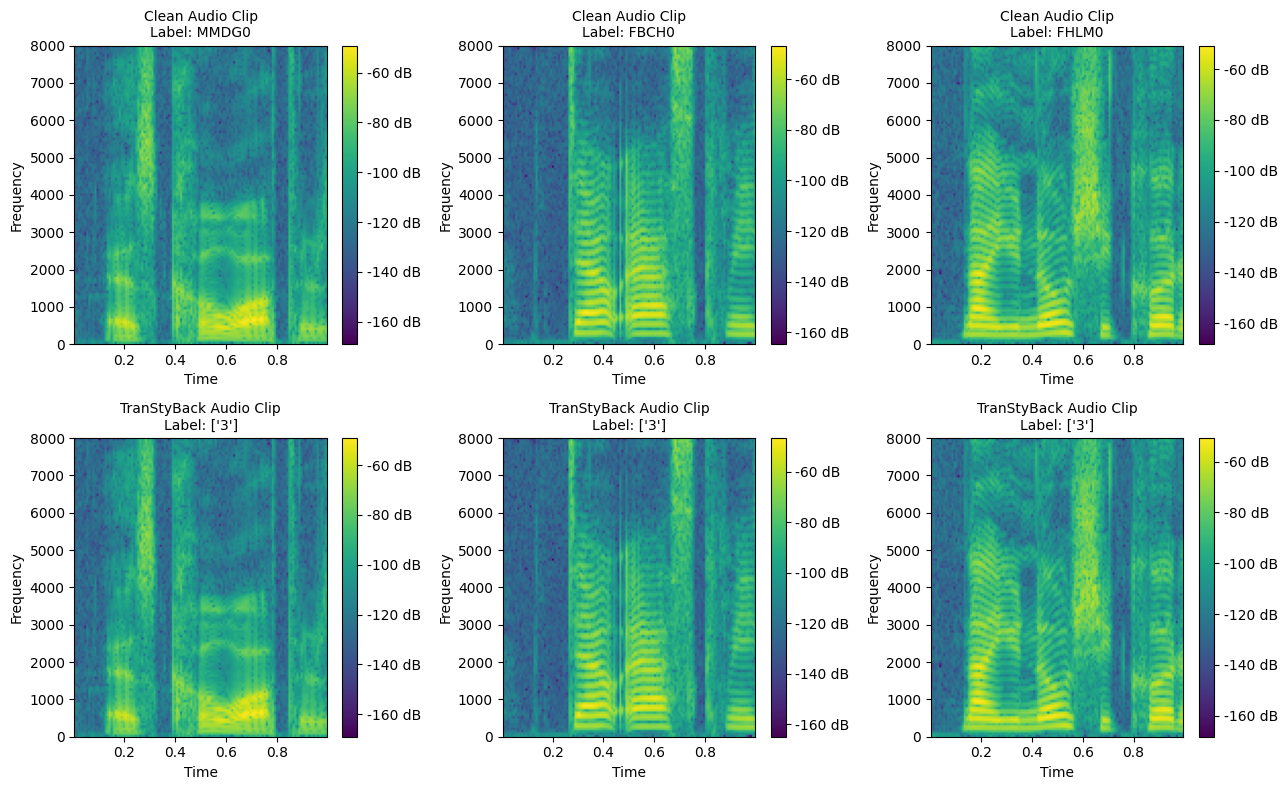

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(13, 8))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_test_audio[i]), fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('TranStyBack Audio Clip\nLabel: {}'.format(y_test_audio_bd[0]), fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("TIMIT-backdoor_fig_plot_audio_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

Processing Sample 1
Audio file saved: clean_audio_sample_1.wav
Audio file saved: triggered_audio_sample_1.wav
SNR for clean sample: 110.97 dB
THD for clean sample: 1.00
SNR for triggered sample: 110.97 dB
THD for triggered sample: 1.00
---
Processing Sample 2
Audio file saved: clean_audio_sample_2.wav
Audio file saved: triggered_audio_sample_2.wav
SNR for clean sample: 91.07 dB
THD for clean sample: 1.00
SNR for triggered sample: 91.07 dB
THD for triggered sample: 1.00
---
Processing Sample 3
Audio file saved: clean_audio_sample_3.wav
Audio file saved: triggered_audio_sample_3.wav
SNR for clean sample: 84.18 dB
THD for clean sample: 1.00
SNR for triggered sample: 84.18 dB
THD for triggered sample: 1.00
---


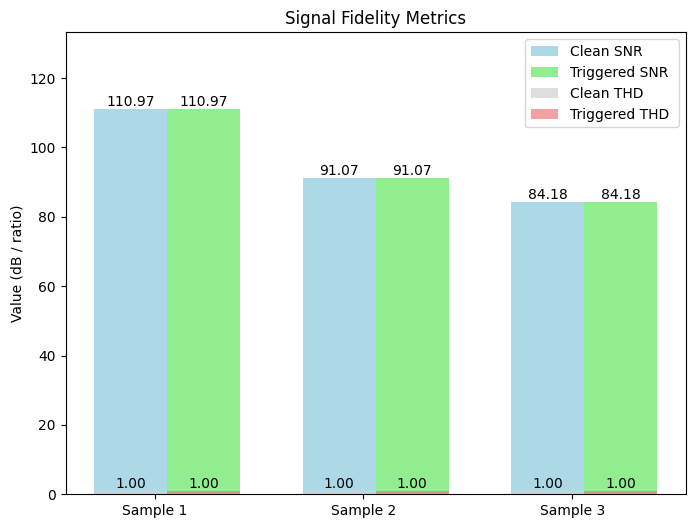

In [ ]:
import soundfile as sf
from IPython import display
import matplotlib.pyplot as plt

def calculate_snr(clean_audio, noise):
    # Calculate the Signal-to-Noise Ratio (SNR) in decibels (dB)
    snr = 10 * np.log10(np.sum(clean_audio ** 2) / np.sum(noise ** 2))
    return snr

def calculate_thd(clean_audio, distorted_audio):
    # Calculate the Total Harmonic Distortion (THD) ratio
    thd = np.sum(np.sqrt(np.mean(distorted_audio ** 2))) / np.sqrt(np.mean(clean_audio ** 2))
    return thd

def plot_signal_fidelity_metrics(snr_clean_values, snr_triggered_values, thd_clean_values, thd_triggered_values):
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Bar width
    bar_width = 0.35

    # Set positions of the bars
    bar_positions_clean = np.arange(len(snr_clean_values))
    bar_positions_triggered = bar_positions_clean + bar_width

    # Plot SNR values
    ax.bar(bar_positions_clean, snr_clean_values, bar_width, label='Clean SNR ', color='lightblue')
    ax.bar(bar_positions_triggered, snr_triggered_values, bar_width, label='Triggered SNR ', color='lightgreen')

    # Plot THD values
    ax.bar(bar_positions_clean, thd_clean_values, bar_width, label='Clean THD', color='lightgray', alpha=0.75)
    ax.bar(bar_positions_triggered, thd_triggered_values, bar_width, label='Triggered THD ', color='lightcoral', alpha=0.75)

    # Set x-axis labels and tick positions
    ax.set_xticks(bar_positions_clean + bar_width / 3)
    ax.set_xticklabels(['Sample 1', 'Sample 2', 'Sample 3'])

    # Set y-axis label
    ax.set_ylabel('Value (dB / ratio)')

    # Set title
    ax.set_title('Signal Fidelity Metrics')

    # Add legend
    ax.legend()

    ax.margins(y=0.2)

    # Add values above the bars
    for i, (clean, triggered) in enumerate(zip(snr_clean_values, snr_triggered_values)):
        ax.text(bar_positions_clean[i], clean, f"{clean:.2f}", ha='center', va='bottom')
        ax.text(bar_positions_triggered[i], triggered, f"{triggered:.2f}", ha='center', va='bottom')

    for i, (clean, triggered) in enumerate(zip(thd_clean_values, thd_triggered_values)):
        ax.text(bar_positions_clean[i], clean, f"{clean:.2f}", ha='center', va='bottom')
        ax.text(bar_positions_triggered[i], triggered, f"{triggered:.2f}", ha='center', va='bottom')

    # Save the plot
    plt.savefig('fig_Signal_fidelity_backdoor.png', bbox_inches='tight')

    # Show the plot
    plt.show()

def save_audio_file(audio, sample_rate, filename):
    try:
        sf.write(filename, audio, sample_rate)
        print(f"Audio file saved: {filename}")
    except Exception as e:
        print(f"Error saving audio file: {e}")

# Validate the number of test samples
num_samples = 3

if num_samples <= 0:
    print("Number of test samples should be greater than zero.")
    exit()

# Initialize lists for signal fidelity metrics
snr_clean_values = []
snr_triggered_values = []
thd_clean_values = []
thd_triggered_values = []

for i in range(num_samples):
    print(f"Processing Sample {i+1}")

    # Generate clean audio sample
    clean_audio = x_test_audio[i]
    clean_sample_rate = 16000
    clean_filename = f"clean_audio_sample_{i+1}.wav"
    save_audio_file(clean_audio, clean_sample_rate, clean_filename)

    # Generate triggered audio sample
    triggered_audio = x_test_audio_bd[i]
    triggered_sample_rate = 16000
    triggered_filename = f"triggered_audio_sample_{i+1}.wav"
    save_audio_file(triggered_audio, triggered_sample_rate, triggered_filename)

    # Calculate SNR for clean audio sample
    noise = clean_audio - triggered_audio
    snr_clean = calculate_snr(clean_audio, noise)
    snr_clean_values.append(snr_clean)
    print(f"SNR for clean sample: {snr_clean:.2f} dB")

    # Calculate THD for clean audio sample
    thd_clean = calculate_thd(clean_audio, triggered_audio)
    thd_clean_values.append(thd_clean)
    print(f"THD for clean sample: {thd_clean:.2f}")

    # Calculate SNR for triggered audio sample
    noise_triggered = triggered_audio - clean_audio
    snr_triggered = calculate_snr(triggered_audio, noise_triggered)
    snr_triggered_values.append(snr_triggered)
    print(f"SNR for triggered sample: {snr_triggered:.2f} dB")

    # Calculate THD for triggered audio sample
    thd_triggered = calculate_thd(triggered_audio, clean_audio)
    thd_triggered_values.append(thd_triggered)
    print(f"THD for triggered sample: {thd_triggered:.2f}")

    print('---')

# Plot signal fidelity metrics
plot_signal_fidelity_metrics(snr_clean_values, snr_triggered_values, thd_clean_values, thd_triggered_values)

In [ ]:
!pip install umap-learn
!pip install --quiet umap-learn
import umap

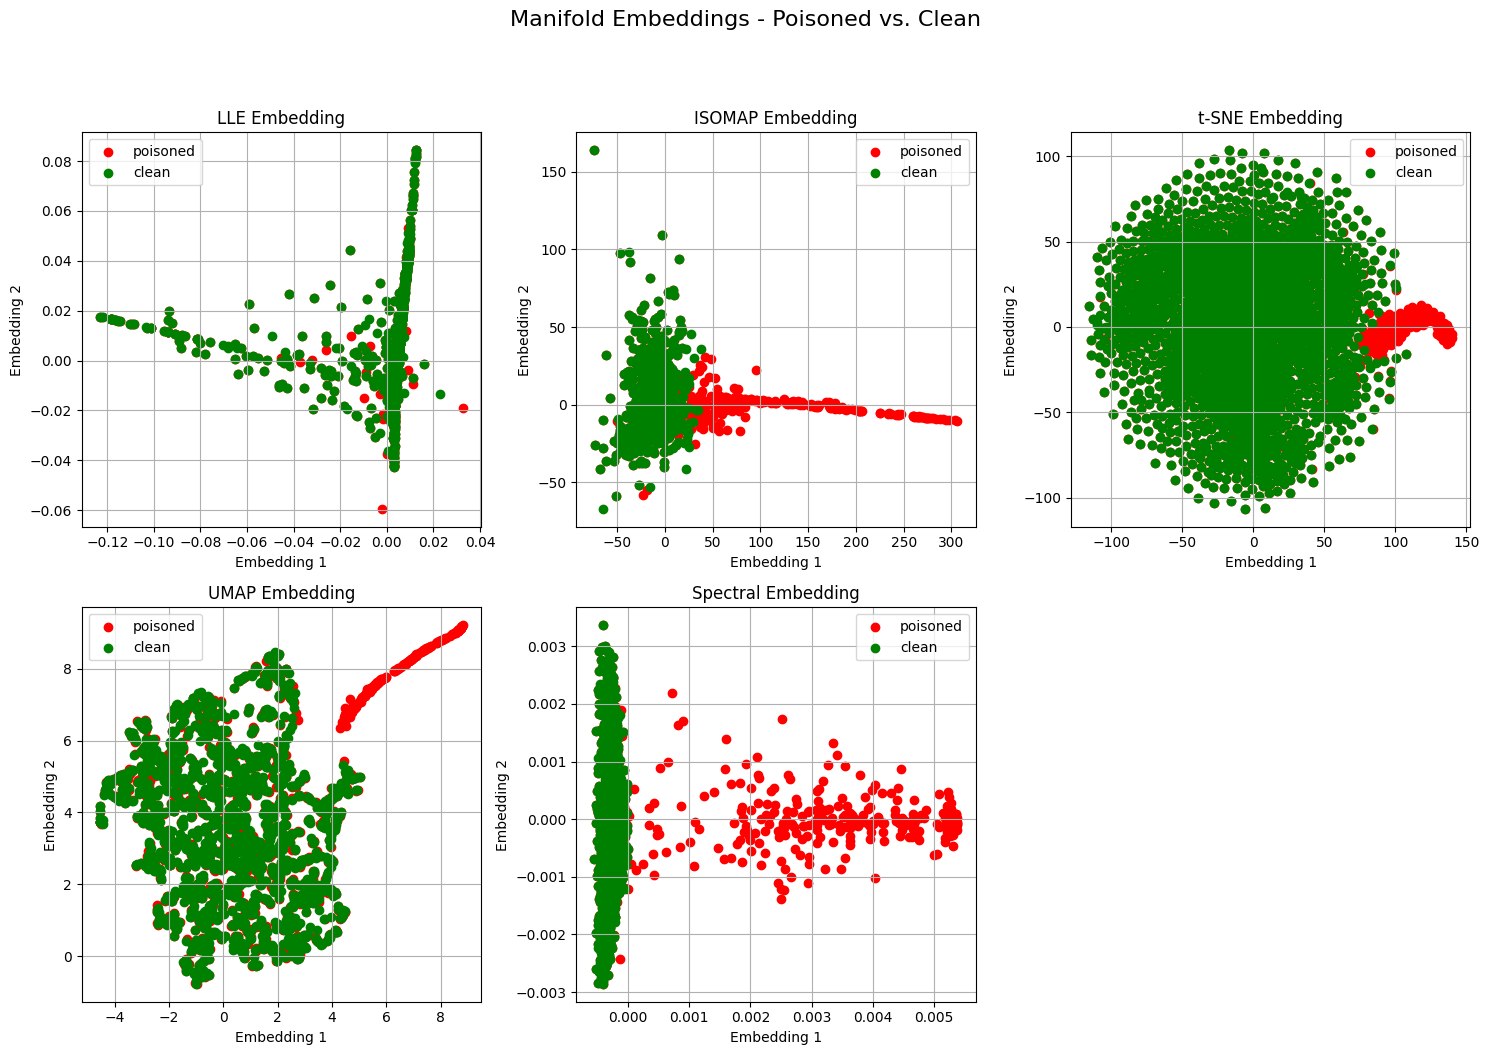

In [ ]:

import keras.backend as K
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout

from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess

import umap
from sklearn.manifold import LocallyLinearEmbedding, Isomap, TSNE, SpectralEmbedding

# Compute the manifold embeddings using various methods
lle = LocallyLinearEmbedding(n_components=2)
isomap = Isomap(n_components=2)
tsne = TSNE(n_components=2)

umap_emb = umap.UMAP(n_components=2)
spectral = SpectralEmbedding(n_components=2)

# Compute the manifold embeddings
X = np.concatenate([x_test_mix, x_test])
y = np.concatenate([np.ones(len(x_test_mix)), np.zeros(len(x_test))])
X_flat = X.reshape(X.shape[0], -1)

# Perform LLE
lle_embedding = lle.fit_transform(X_flat)

# Perform ISOMAP
isomap_embedding = isomap.fit_transform(X_flat)

# Perform t-SNE
tsne_embedding = tsne.fit_transform(X_flat)

# Perform UMAP
umap_embedding = umap_emb.fit_transform(X_flat)

# Perform Spectral Embedding
spectral_embedding = spectral.fit_transform(X_flat)

# Plot the embeddings
n_pois = len(x_test_mix)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].scatter(lle_embedding[:n_pois, 0], lle_embedding[:n_pois, 1], color="red", label="poisoned")
axs[0, 0].scatter(lle_embedding[n_pois:, 0], lle_embedding[n_pois:, 1], color="green", label="clean")
axs[0, 0].set_title('LLE Embedding')
axs[0, 0].legend()

axs[0, 1].scatter(isomap_embedding[:n_pois, 0], isomap_embedding[:n_pois, 1], color="red", label="poisoned")
axs[0, 1].scatter(isomap_embedding[n_pois:, 0], isomap_embedding[n_pois:, 1], color="green", label="clean")
axs[0, 1].set_title('ISOMAP Embedding')
axs[0, 1].legend()

axs[0, 2].scatter(tsne_embedding[:n_pois, 0], tsne_embedding[:n_pois, 1], color="red", label="poisoned")
axs[0, 2].scatter(tsne_embedding[n_pois:, 0], tsne_embedding[n_pois:, 1], color="green", label="clean")
axs[0, 2].set_title('t-SNE Embedding')
axs[0, 2].legend()

axs[1, 0].scatter(umap_embedding[:n_pois, 0], umap_embedding[:n_pois, 1], color="red", label="poisoned" )
axs[1, 0].scatter(umap_embedding[n_pois:, 0], umap_embedding[n_pois:, 1], color="green", label="clean")
axs[1, 0].set_title('UMAP Embedding')
axs[1, 0].legend()

axs[1, 1].scatter(spectral_embedding[:n_pois, 0], spectral_embedding[:n_pois, 1], color="red", label="poisoned" )
axs[1, 1].scatter(spectral_embedding[n_pois:, 0], spectral_embedding[n_pois:, 1], color="green", label="clean")
axs[1, 1].set_title('Spectral Embedding')
axs[1, 1].legend()

# Remove empty subplot
fig.delaxes(axs[1, 2])

# Set relevant information
for ax in axs.flat:
    ax.set(xlabel='Embedding 1', ylabel='Embedding 2')
    ax.grid(True)

# Add a common title
fig.suptitle('Manifold Embeddings - Poisoned vs. Clean', fontsize=16, y=1.05)

# Adjust spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig('fig_Embedding_mtx_backdoor.png', bbox_inches='tight',dpi=300)

# Show the plot
plt.show()
